In [413]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from pysheds.grid import Grid
import pyproj
import rasterio
from rasterio.merge import merge
import glob
import gdal

# import seaborn as

import warnings
import pandas as pd
warnings.filterwarnings('ignore')
import georasters as gr
%matplotlib inline

In [424]:
hand

Raster([[nan, nan, nan, ..., nan, nan, nan],
        [nan, 19., 70., ..., 41., 42., nan],
        [nan, 18., 15., ..., 41., 54., nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]])

In [326]:
grid = Grid.from_raster('/Users/oscarkeunen/Downloads/s15e020_con_grid/s15e020_con/s15e020_con', data_name='dem')
grid1 = Grid.from_raster('/Users/oscarkeunen/Downloads/s20e020_con_grid/s20e020_con/s20e020_con', data_name='dem1')
grid.read_raster('/Users/oscarkeunen/Downloads/s15e020_dir_grid/s15e020_dir/s15e020_dir', data_name='dir')
grid1.read_raster('/Users/oscarkeunen/Downloads/s20e020_dir_grid/s20e020_dir/s20e020_dir', data_name='dir1')

grid.accumulation(data='dir', out_name='acc')
grid1.accumulation(data='dir1', out_name='acc1')
hand = grid.compute_hand('dir', 'dem', grid.acc > 50, inplace=False)
hand1 = grid1.compute_hand('dir1', 'dem1', grid1.acc1 > 50, inplace=False)



In [375]:
grid.extent
# grid1.dem1.coords

(20.0, 25.000833333333134, -15.000833333333333, -10.000000000000199)

Text(0, 0.5, 'Latitude')

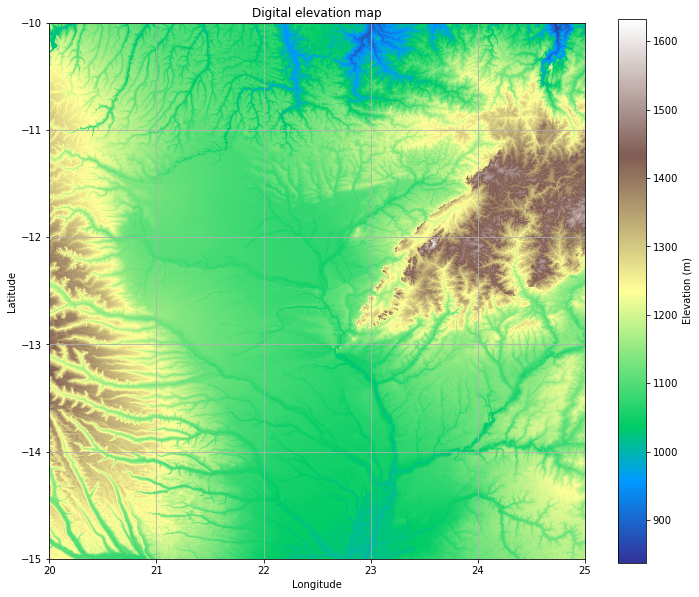

In [377]:

fig, ax = plt.subplots(figsize=(12,10))


plt.imshow(grid.dem, extent=grid.extent, cmap='terrain', zorder=1)




plt.colorbar(label='Elevation (m)')
plt.grid(zorder=0)
plt.title('Digital elevation map')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# plt.savefig('img/conditioned_dem.png', bbox_inches='tight')


In [332]:
points = pd.read_csv('pointsofinterest_new.csv')
points_interest = [(points.xcoord[0],points.ycoord[0]),
                   (points.xcoord[1],points.ycoord[1]),
                   (points.xcoord[2],points.ycoord[2]),
                   (points.xcoord[3],points.ycoord[3]),
                   (points.xcoord[4],points.ycoord[4]),
                   (points.xcoord[5],points.ycoord[5]) ]
x, y = zip(*points_interest)
(points.xcoord[1],points.ycoord[1])

(23.005539794544802, -14.895900574814998)

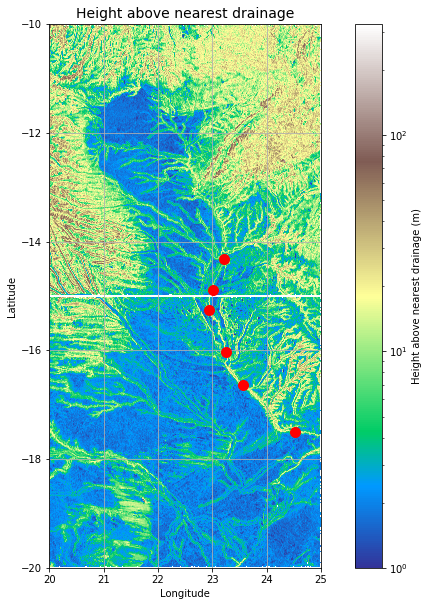

In [399]:
fig, ax = plt.subplots(figsize=(12,10))


plt.imshow(hand +1 , zorder=1, cmap='terrain', interpolation='bilinear',norm=colors.LogNorm(vmin=1, vmax=np.nanmax(hand)), extent=grid.extent)
plt.imshow(hand1 +1, zorder=1, cmap='terrain', interpolation='bilinear',norm=colors.LogNorm(vmin=1, vmax=np.nanmax(hand1)), extent=grid1.extent)


# plt.imshow(hand1 + 1, zorder=1, cmap='terrain', interpolation='bilinear',
#            norm=colors.LogNorm(vmin=1, vmax=np.nanmax(hand)), extent=grid.extent)

ax.plot(x, y, color='r', marker='.', markersize=20, linewidth=0.)
plt.colorbar(label='Height above nearest drainage (m)')
plt.title('Height above nearest drainage', size=14)


# ax.set_xlim(grid.bbox[0], grid.bbox[2])
# ax.set_ylim(grid.bbox[1], grid.bbox[3])
plt.grid(zorder=0)
plt.xlabel('Longitude')
plt.ylabel('Latitude')



plt.savefig('HAND1_1.raw')

Text(0, 0.5, 'Latitude')

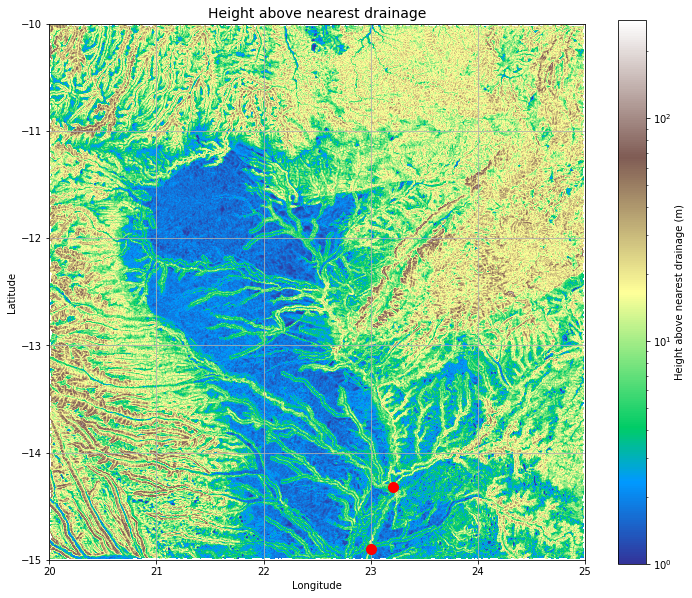

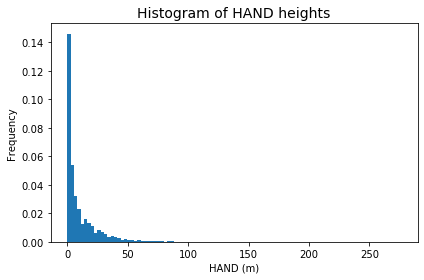

In [218]:
# fig, ax = plt.subplots(figsize=(8, 4))
h = plt.hist(hand[~np.isnan(hand)], bins=100, normed=True)
plt.title('Histogram of HAND heights', size=14)
plt.ylabel('Frequency')
plt.xlabel('HAND (m)')
plt.tight_layout()




Text(0, 0.5, 'Latitude')

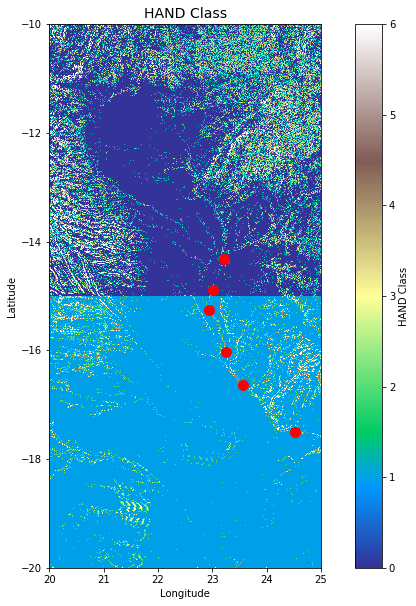

In [394]:
_, bins = np.histogram(hand[~np.isnan(hand) & (hand < 50)], bins=5)
classes = np.digitize(hand, bins)
# _,bins1 = np.histogram(hand1[~np.isnan(hand1) & (hand1 < 50)], bins=5)
classes1 = np.digitize(hand1, bins) 

fig, ax = plt.subplots(figsize=(12,10))
plt.imshow(classes, zorder=1, cmap='terrain', extent=grid.extent)
plt.imshow(classes1, zorder=1, cmap='terrain', extent=grid1.extent)

plt.colorbar(label='HAND Class')
plt.title('HAND Class', size=14)

ax.plot(x, y, color='r', marker='.', markersize=20, linewidth=0.)
plt.xlabel('Longitude')
plt.ylabel('Latitude')


In [283]:

grid.resolve_flats('dem', out_name='inflated_dem')

grid.fill_depressions(data='dem', out_name='flooded_dem')

In [284]:

dirmap = (1, 2, 3, 4, 5, 6, 7, 8)
grid.flowdir(data='inflated_dem', out_name='dir', dirmap=dirmap)



(6000, 6000)

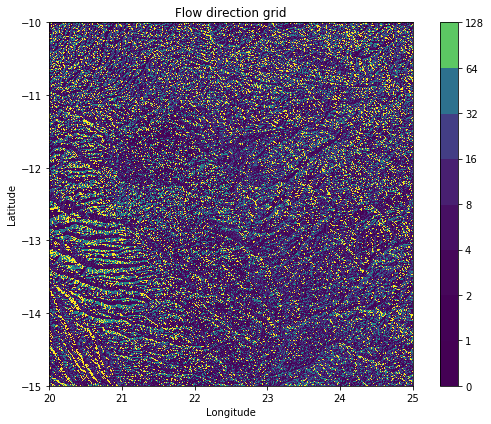

In [226]:
#N    NE    E    SE    S    SW    W    NW
# dirmap = (64,  128,  1,   2,    4,   8,    16,  32)
fig = plt.figure(figsize=(8,6))
fig.patch.set_alpha(0)

plt.imshow(grid.dir, extent=grid.extent, cmap='viridis', zorder=2)
boundaries = ([0] + sorted(list(dirmap)))
plt.colorbar(boundaries= boundaries)
#              values=sorted(dirmap))
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Flow direction grid')
plt.grid(zorder=-1)
plt.tight_layout()

In [404]:

grid.dir.size

36000000

In [313]:
grid.dir.size +1000

36001000

In [409]:
dirmap = (64,  128,  1,   2,    4,   8,    16,  32)

acc = grid.accumulation(data='dir', dirmap=dirmap, inplace=False, nodata_in=0,
                        ignore_metadata=True)

In [406]:

# Specify pour point (greatest accumulation)
y, x = np.unravel_index(np.argmax(acc), acc.shape)


# Delineate the catchment
catch = grid.catchment(data='dir', x=x, y=y, dirmap=dirmap, inplace=False,
                       recursionlimit=150000, xytype='index', nodata_in=0,
                       ignore_metadata=True)


fig, ax = plt.subplots(figsize=(8,6))
im = ax.imshow(np.where(catch, dem, np.nan), cmap='cubehelix', zorder=1)
plt.colorbar(im, label='Elevation (m)')
plt.grid(zorder=0)
plt.title('Digital elevation map')
plt.tight_layout()


# fig, ax = plt.subplots(figsize=(8,6))
# fig.patch.set_alpha(0)

# plt.grid('on', zorder=0)
# im = ax.imshow(catch, extent=grid.extent, zorder=1, cmap='viridis')
# plt.colorbar(im, ax=ax, boundaries=boundaries, values=sorted(dirmap), label='Flow Direction')
# plt.xlabel('Longitude')
# plt.ylabel('Latitude')
# plt.title('Delineated Catchment')

IndexError: index 36003552 is out of bounds for size 36000000

Text(0.5, 1.0, 'Delineated Catchment')

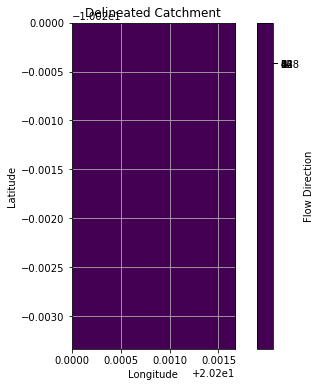

In [211]:
# Plot the catchment
fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_alpha(0)

plt.grid('on', zorder=0)
im = ax.imshow(catch, extent=grid.extent, zorder=1, cmap='viridis')
plt.colorbar(im, ax=ax, boundaries=boundaries, values=sorted(dirmap), label='Flow Direction')
ax.set_xlim(grid.bbox[0], grid.bbox[2])
ax.set_ylim(grid.bbox[1], grid.bbox[3])
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Delineated Catchment')
